In [1]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034_Yellow_Taxi_Modelling")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/08/22 17:53:15 WARN Utils: Your hostname, LAPTOP-VAB0S7AL resolves to a loopback address: 127.0.1.1; using 172.27.239.27 instead (on interface eth0)
22/08/22 17:53:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/08/22 17:53:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/22 17:53:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/22 17:53:17 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
# read in cleaned 2019 taxi+weather data & confirm
sdf = spark.read.parquet('../data/curated//yt2019_cleaned.parquet')

In [3]:
sdf.limit(5)

VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge,PU_hourofday,DO_hourofday,PU_dayofweek,DO_dayofweek,PU_dayofmonth,DO_dayofmonth,PU_month,DO_month,trip_time_minutes,trip_speed_mph,fare_per_minute,tmpf,dwpf,relh
1,1.0,1.9,1,230,170,2,15.0,2.5,16,16,6,19,19,19,7,7,24.15,4.720496894409938,0.6211180124223603,86.0,75.0,69.8
1,1.0,1.9,1,143,161,1,17.0,2.5,16,16,6,19,19,19,7,7,27.366666666666667,4.165651644336175,0.6211936662606578,86.0,75.0,69.8
2,1.0,2.99,1,233,146,1,14.0,2.5,16,16,6,19,19,19,7,7,17.25,10.400000000000002,0.8115942028985508,86.0,75.0,69.8
2,1.0,0.97,1,233,137,2,6.5,2.5,16,16,6,19,19,19,7,7,7.366666666666666,7.900452488687782,0.8823529411764707,86.0,75.0,69.8
2,1.0,0.59,1,137,164,2,5.0,2.5,16,17,6,19,19,19,7,7,5.233333333333333,6.764331210191082,0.9554140127388535,86.0,75.0,69.8


### Correlation Matrix

In [6]:
#CORR_COLS = ["passenger_count", "trip_distance", "RatecodeID", ]
CORR_COLS = ["trip_distance", "fare_amount", "congestion_surcharge",
             "trip_time_minutes", "trip_speed_mph", "fare_per_minute",
             "tmpf", "dwpf", "relh"]

#"RatecodeID"
# "passenger_count",

In [7]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

/home/noahs/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
features = "correlation_features"
assembler = VectorAssembler(
    inputCols = CORR_COLS,
    outputCol = features
)

# convert sdf columns to a single vector
feature_vector = assembler.transform(sdf.dropna('any')).select(features)
corr_matrix_dense = Correlation.corr(feature_vector, features)

22/08/22 17:50:56 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/08/22 17:50:56 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [9]:
# collect results from pyspark correlation
corr_matrix_dense.collect()
corr_matrix = corr_matrix_dense.collect()[0][0].toArray().tolist()
df_corr = pd.DataFrame(corr_matrix, index=CORR_COLS, columns=CORR_COLS)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

/home/noahs/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


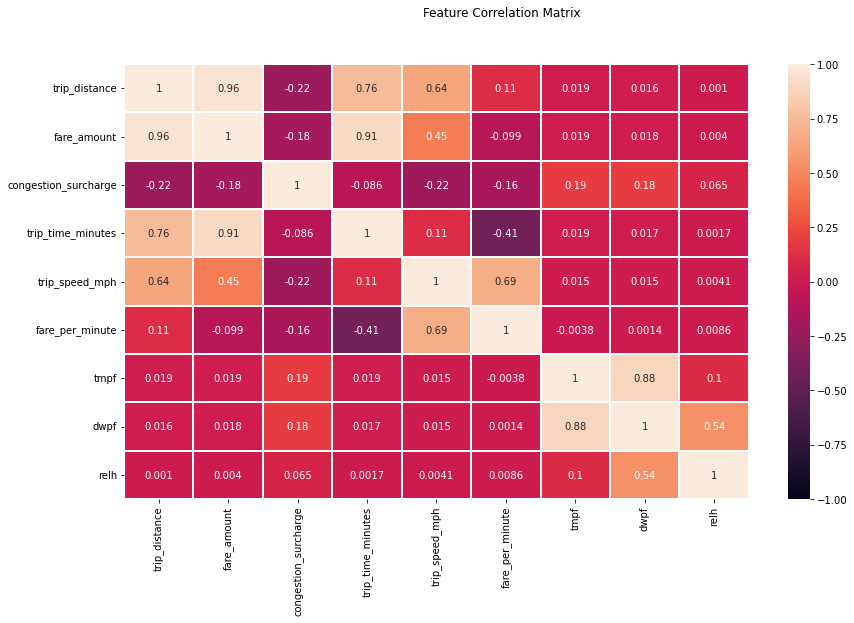

In [11]:
#df_corr
f = plt.figure(figsize=(14,8))
vis_matrix = sns.heatmap(df_corr, annot=True, linewidths=0.1, vmax=1, vmin=-1)
vis_matrix.figure.suptitle("Feature Correlation Matrix")
vis_matrix.figure.savefig("../plots/corr_matrix.png")

* month and avg(dwpf), tmp, relh correlated
* trip_speed_mph and fare_amount correlated
* trip_time_minutes and fare_amount correlated
* fare amount and congestion surcharge
* congestion surcharge and month, dayofweek, tripspeed,
* new features consistently correlate with their parents

In [3]:
# sample for visualisations
df = sdf.select('fare_amount', 'trip_distance', 'trip_time_minutes', 'congestion_surcharge', 'tmpf').sample(fraction=0.03, seed=0, withReplacement=False).toPandas()

### Scatterplot matrix of Fare amount, trip time, trip distance

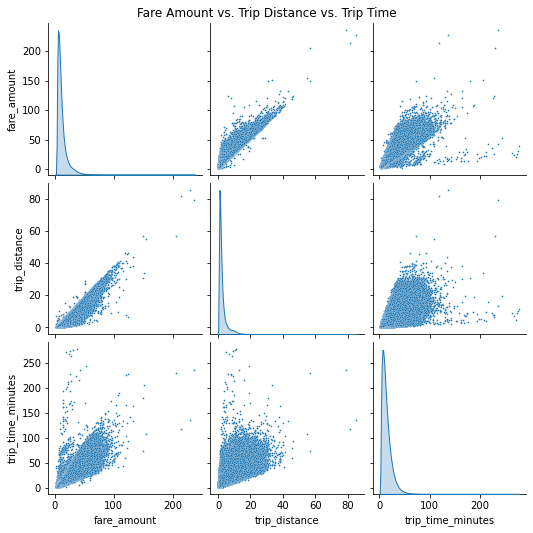

In [6]:
# before log transformation
featuers_pp = sns.pairplot(df[['fare_amount', 'trip_distance', 'trip_time_minutes']],plot_kws={"s": 3}, diag_kind='kde')
featuers_pp.fig.subplots_adjust(top=0.95)
featuers_pp.fig.suptitle("Fare Amount vs. Trip Distance vs. Trip Time")
featuers_pp.savefig("../plots/features_pairplot.png")


#.set(xlabels=('Fare Amount', 'Trip Distance', 'Trip Time'))


In [7]:
#plt.legend(,
#                   title='Fare Amount vs. Trip Distance vs. Trip Time')
labels=['Fare Amount',
        'Trip Distance',
        'Trip Time (minutes)']


In [8]:
import numpy as np
import pandas as pd

for x in df:
    if x in ['fare_amount', 'trip_distance', 'trip_time_minutes']:
        temp = 'log(' + x + ')'
        df[temp] = np.log(df[x])

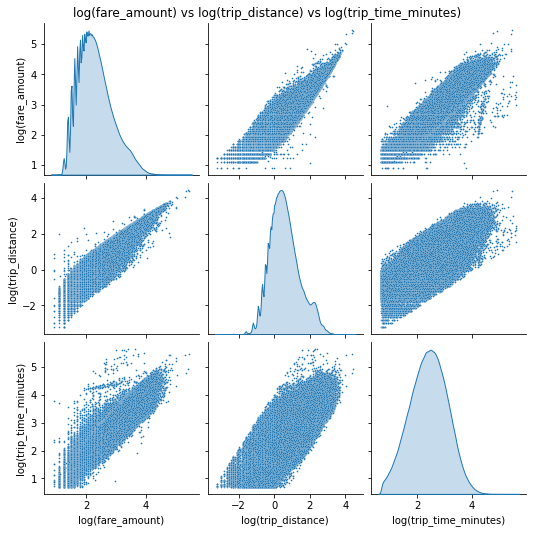

In [9]:
# pairplot of features
log_features_pp = sns.pairplot(df[['log(fare_amount)', 'log(trip_distance)', 'log(trip_time_minutes)']], plot_kws={"s": 3}, diag_kind='kde')
log_features_pp.fig.subplots_adjust(top=0.95)
log_features_pp.fig.suptitle('log(fare_amount) vs log(trip_distance) vs log(trip_time_minutes)')
log_features_pp.savefig('../plots/log_features_pairplot.png')

# might have to change s to smaller value with more points

* Shows almost perfect linear correlation

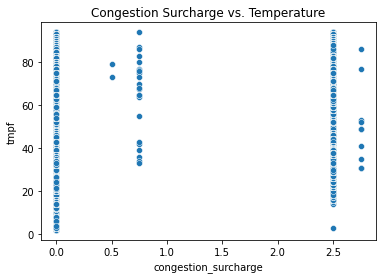

In [10]:
con_vs_tmpf = sns.scatterplot(x=df['congestion_surcharge'], y=df['tmpf'])
con_vs_tmpf.set(title = "Congestion Surcharge vs. Temperature")
con_vs_tmpf.figure.savefig("../plots/con_vs_tmpf.png")

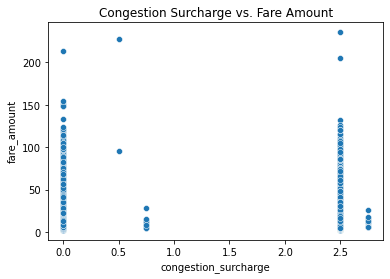

In [ ]:
con_vs_fare = sns.scatterplot(x=df['congestion_surcharge'], y=df['fare_amount'])
con_vs_fare.set(title = "Congestion Surcharge vs. Fare Amount")
con_vs_fare.figure.savefig("../plots/con_vs_fare.png")